In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer, confusion_matrix, fbeta_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier, ExtraTreesClassifier
import xgboost as xgb
import lightgbm as lgb 

In [15]:
X_train = pd.read_csv('./model_csv/X_train_Kickstarter.csv')
X_test = pd.read_csv('./model_csv/X_test_Kickstarter.csv')
y_train = pd.read_csv('./model_csv/y_train_Kickstarter.csv')
y_test = pd.read_csv('./model_csv/y_test_Kickstarter.csv')
y_train = y_train['state']
y_test = y_test['state']

In [16]:
RSEED=42

# Dummy Classifier

In [17]:
dummy_clf = DummyClassifier(strategy = 'most_frequent')

In [18]:
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [19]:
y_pred = dummy_clf.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     22545
           1       0.61      1.00      0.76     35190

    accuracy                           0.61     57735
   macro avg       0.30      0.50      0.38     57735
weighted avg       0.37      0.61      0.46     57735



In [21]:
cnf_matrix = confusion_matrix(y_test, y_pred)

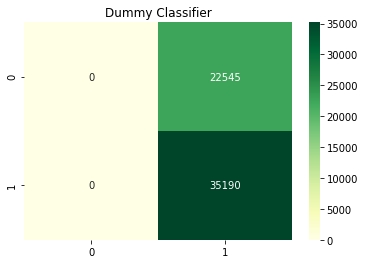

In [22]:
ax = plt.axes()
sns.heatmap(cnf_matrix, annot = True, fmt = "g", cmap='YlGn', ax=ax)
ax.set_title('Dummy Classifier')
plt.show();

# SVM Classifier

In [23]:
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train_scaled = scaling.transform(X_train)
X_test_scaled = scaling.transform(X_test)

In [24]:
svm_clf = SVC(kernel='linear', verbose = 5)

In [25]:
#svm_clf.fit(X_train_scaled, y_train)
#dump(clf, 'clfSVM.pickle')

In [26]:
svm_clf = load('clfSVM.pickle')

In [27]:
y_pred_svm = svm_clf.predict(X_test_scaled)

In [31]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.65      0.71      0.68     22545
           1       0.80      0.75      0.78     35190

    accuracy                           0.74     57735
   macro avg       0.72      0.73      0.73     57735
weighted avg       0.74      0.74      0.74     57735



In [28]:
confm_svm = confusion_matrix(y_test, y_pred_svm)

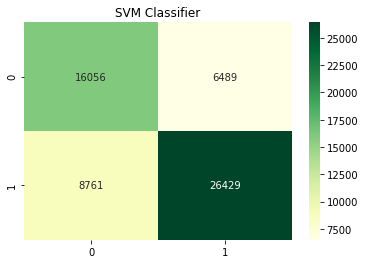

In [29]:
ax = plt.axes()
sns.heatmap(confm_svm, annot = True, fmt = "g", cmap='YlGn', ax=ax)
ax.set_title('SVM Classifier')
plt.show();

# KNN Classifier

In [24]:
knn_clf = KNeighborsClassifier(n_neighbors=5, metric='minkowski', n_jobs=-1)

In [25]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1)

In [27]:
#y_pred_knn = knn_clf.predict(X_test)
y_pred_knn = np.ones(len(y_test))

In [28]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     22545
           1       0.61      1.00      0.76     35190

    accuracy                           0.61     57735
   macro avg       0.30      0.50      0.38     57735
weighted avg       0.37      0.61      0.46     57735



In [31]:
confm_knn = confusion_matrix(y_test, y_pred_knn)

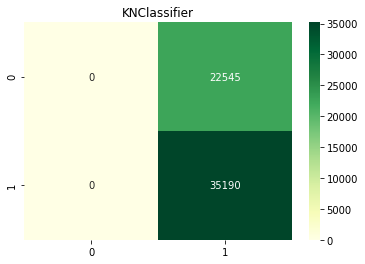

In [32]:
ax = plt.axes()
sns.heatmap(confm_knn, annot = True, fmt = "g", cmap='YlGn', ax=ax)
ax.set_title('KNClassifier')
plt.show();

# SGDClassifier

In [22]:
sgd_clf = SGDClassifier(loss='hinge', max_iter=1000, alpha=0.0001, random_state=RSEED)

In [23]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [24]:
y_pred_sgd = sgd_clf.predict(X_test)

In [25]:
print(classification_report(y_test, y_pred_sgd))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50     22545
           1       0.68      0.68      0.68     35190

    accuracy                           0.61     57735
   macro avg       0.59      0.59      0.59     57735
weighted avg       0.61      0.61      0.61     57735



In [26]:
confm_sgd = confusion_matrix(y_test, y_pred_sgd)

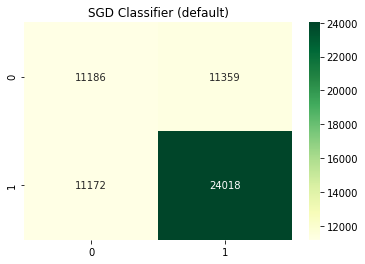

In [27]:
ax = plt.axes()
sns.heatmap(confm_sgd, annot = True, fmt = "g", cmap='YlGn', ax=ax)
ax.set_title('SGD Classifier (default)')
plt.show();

# SGD Classifier - GridSearch

In [28]:
sgd_gs_clf = SGDClassifier(max_iter=1000, random_state=RSEED)

In [29]:
param_grid = {"loss" : ["hinge", "log"],
              "alpha" : [0.0001, 0.001, 0.01, 0.1],
              "penalty" : ["l2", "elasticnet"]
             }

In [30]:
gs = GridSearchCV(sgd_gs_clf, param_grid, scoring='accuracy', cv=5, verbose=5, n_jobs=-1)

In [31]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=SGDClassifier(random_state=42), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1],
                         'loss': ['hinge', 'log'],
                         'penalty': ['l2', 'elasticnet']},
             scoring='accuracy', verbose=5)

In [32]:
# Best score
print('Best score:', round(gs.best_score_, 3))
# Best parameters
print('Best parameters:', gs.best_params_)

Best score: 0.629
Best parameters: {'alpha': 0.01, 'loss': 'log', 'penalty': 'l2'}


In [33]:
y_pred_gs = gs.best_estimator_.predict(X_test)

In [34]:
print(classification_report(y_test, y_pred_gs))

              precision    recall  f1-score   support

           0       0.50      0.49      0.50     22545
           1       0.68      0.69      0.68     35190

    accuracy                           0.61     57735
   macro avg       0.59      0.59      0.59     57735
weighted avg       0.61      0.61      0.61     57735



In [35]:
confm_gs = confusion_matrix(y_test, y_pred_gs)

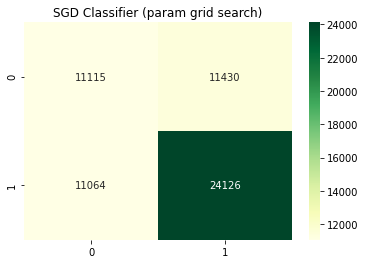

In [36]:
ax = plt.axes()
sns.heatmap(confm_gs, annot = True, fmt = "g", cmap='YlGn', ax=ax)
ax.set_title('SGD Classifier (param grid search)')
plt.show();

# ADA Boost

# LightGBM

In [37]:
lgb_clf = lgb.LGBMClassifier()

In [38]:
lgb_clf.fit(X_train, y_train)

LGBMClassifier()

In [39]:
y_pred_lgb = lgb_clf.predict(X_test)

In [40]:
print(classification_report(y_test, y_pred_lgb))

              precision    recall  f1-score   support

           0       0.72      0.71      0.71     22545
           1       0.82      0.82      0.82     35190

    accuracy                           0.78     57735
   macro avg       0.77      0.77      0.77     57735
weighted avg       0.78      0.78      0.78     57735



In [41]:
confm_lgb = confusion_matrix(y_test, y_pred_lgb)

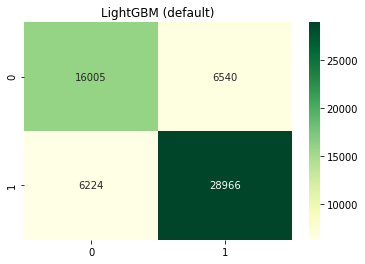

In [42]:
ax = plt.axes()
sns.heatmap(confm_lgb, annot = True, fmt = "g", cmap='YlGn', ax=ax)
ax.set_title('LightGBM (default)')
plt.show();

# LightGBM GridSearchCV

In [43]:
model = lgb.LGBMClassifier(random_state=RSEED)

In [44]:
params_lgb = {
    'n_estimators': [100, 400, 700],   # default 100
    #'colsample_bytree': [0.7, 0.8, 1.],   # default 1.
    'max_depth': [-1, 60, 120],          # default -1
    #'num_leaves': [31, 50, 100],      # default 31
    #'reg_alpha': [0., 1.1, 1.2],     # default 0.
    #'reg_lambda': [0., 1.1, 1.2],     # default 0.
    #'min_split_gain': [0.3, 0.4],     # default 0.
    #'subsample': [0.7, 0.8, 0.9],     # default 1.
    #'subsample_freq': [20]     # default 0
    }


In [45]:
gs_lgb = GridSearchCV(model, param_grid=params_lgb, scoring='accuracy', cv=5, verbose=5, n_jobs=-1)

In [46]:
gs_lgb.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [-1, 60, 120],
                         'n_estimators': [100, 400, 700]},
             scoring='accuracy', verbose=5)

In [47]:
# Best score
print('Best score:', round(gs_lgb.best_score_, 3))
# Best parameters
print('Best parameters:', gs_lgb.best_params_)

Best score: 0.785
Best parameters: {'max_depth': -1, 'n_estimators': 700}


In [48]:
y_pred_gs_lgb = gs_lgb.best_estimator_.predict(X_test)

In [49]:
print(classification_report(y_test, y_pred_gs_lgb))

              precision    recall  f1-score   support

           0       0.73      0.72      0.73     22545
           1       0.82      0.83      0.83     35190

    accuracy                           0.79     57735
   macro avg       0.78      0.78      0.78     57735
weighted avg       0.79      0.79      0.79     57735



In [50]:
confm_gs_lgb = confusion_matrix(y_test, y_pred_gs_lgb)

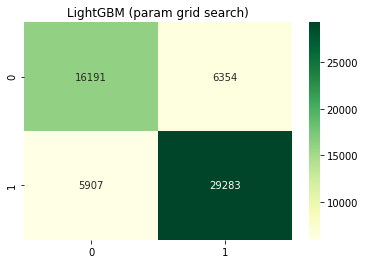

In [51]:
ax = plt.axes()
sns.heatmap(confm_gs_lgb, annot = True, fmt = "g", cmap='YlGn', ax=ax)
ax.set_title('LightGBM (param grid search)')
plt.show();

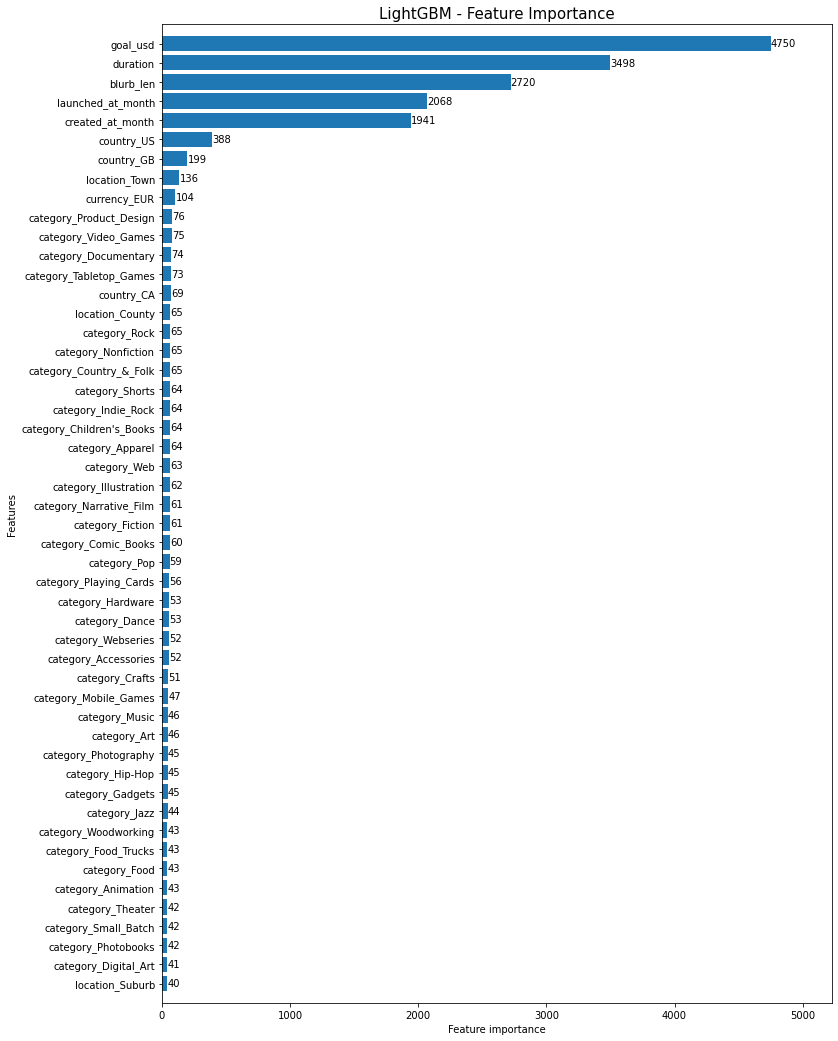

In [60]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(gs_lgb.best_estimator_, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.savefig('feature_importance_top50_lightgbm.png')

In [61]:
#dump(gs_lgb.best_estimator_, "lgb_079acc.pickle")

['lgb_079acc.pickle']

In [62]:
a = load("./lgb_079acc.pickle")
a.get_params()

# XGBoost

In [53]:
xgb_clf = xgb.XGBClassifier()

In [54]:
xgb_clf.fit(X_train, y_train)

[22:58:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
y_pred_xgb = xgb_clf.predict(X_test)

In [56]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.72      0.70      0.71     22545
           1       0.81      0.83      0.82     35190

    accuracy                           0.78     57735
   macro avg       0.77      0.76      0.76     57735
weighted avg       0.78      0.78      0.78     57735



In [57]:
confm_xgb = confusion_matrix(y_test, y_pred_xgb)

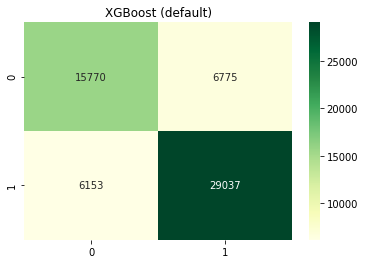

In [58]:
ax = plt.axes()
sns.heatmap(confm_xgb, annot = True, fmt = "g", cmap='YlGn', ax=ax)
ax.set_title('XGBoost (default)')
plt.show();

# Naive Bayes

In [9]:
nb_clf = BernoulliNB()

In [10]:
nb_clf.fit(X_train, y_train)

BernoulliNB()

In [11]:
y_pred_nb = nb_clf.predict(X_test)

In [12]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66     22545
           1       0.78      0.78      0.78     35190

    accuracy                           0.73     57735
   macro avg       0.72      0.72      0.72     57735
weighted avg       0.73      0.73      0.73     57735



In [18]:
confm_nb = confusion_matrix(y_test, y_pred_nb)

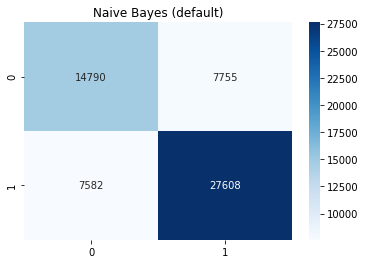

In [22]:
ax = plt.axes()
sns.heatmap(confm_nb, annot = True, fmt = "g", cmap='Blues', ax=ax)
ax.set_title('Naive Bayes (default)')
plt.show();